# Machine Learning Engineer Nanodegree
## Capstone Project - Toxic Comments Classification
### Hui Wang
### Feburary 18th, 2018


## I. Definition

### Project Overview
Natural language processing (NLP) provides methods and tools to analyze, understand and derive meanings from human language. Some well-known use cases for NLP are: automatic summarization of speeches or texts, translation, sentiment analysis, speech recognition, topic segmentation, and etc. NLP is an active research area, and the development in this area is closely related to people's life. For example, a chat bot based on Point-of-Speech tagging can provide customer service at 24/7; a summarizer can extract the most important and essential ideas of text blocks while ignoring irrelavant information; a text-reader application that converts text blocks to audible speech can make it more convenience for people with poor vision. The impact on daily life is also my primary motivation of choosing a specific topic in this area as my capstone project.  

The problem I will try to solve in this project is to classify toxic comments into different categories (a Kaggle dataset). Online conversation can be difficult. Many people stop trying to express themselves and give up on seeking different opinions, due to the threat of abuse and harassment online. It has been a request from online platforms to host a healthy environment to foster and encourage people to discuss the topics that they care about. There exist models that identify toxic comments, however, the models still make erorrs, and they don't allow users to specifically select the categories of toxic comments they want to find.  

### Problem Statement
A training dataset of comments from Wikipedia's talk page edits will be used. The target labels are severity of toxic, and specific categories: threats, obscenity, insults, and identity-based hate. The task is to predict the toxic severity of a comment and the probability for a given comment to fall into each of the toxic categories. The performance of the model will be evaluated by the average column-wise log loss, where each column represents a severity or a category, and each row represents a comment.


### Metrics
We'd like to evaluate the prediction performance of the model, i.e., if it is able to classify a given comment as "non-toxic", "toxic", "severe-toxic", "obscene","threat","insult", or "identity_hate" correctly. For that purpose the performance of models will be evaluated by two metrics - log loss and area under receiver of characteristics curve, individually on each of the six category. The two metrics are then taken average over the categories to produce metrics that represents performance for each model.

- Log loss

Log loss is a common and popular metric to evaluate binary and multiple classification models. Mathematically, the log loss is defined as below, where N is the total number of data points, M is the number of classes to be predicted, $y_{ij}$ is a binary indicator that if data point i is truely in class j, and $p_{ij}$ is the predicted probability for data point i being in class j. 

$ log\ loss = −\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{M} y_{ij}\log p_{ij}$

We can further understand why log loss is a good metric to evaluate classifiers by taking binary classifiers as an example. Consider a perfect classifier that predicts each data point to be in its true class with probability 1, i.e., $p_{ij}$ equals to 1 whenever $y_{ij}$ equals to 1, and $p_{ij}$ equals to 0 whenever $y_{ij}$ equals to 0. According to the log loss formulation above, this perfect classifier will have a value of 0. Consider a bad binary classifier, that always predicts the class opposite to the true value with probability 1, then the log loss will turn to be infity (think of a summation over $\log 0). Log loss for multi-class classifier has similar character.

Intuitively, the smaller log loss the better the classifier does, similarly, the larger the log loss the worse the classifier does. 

- AUROC

AUROC stands for area on the reciever of characteristic curve. It's a common metric to evaluate the goodness of binary classifier, as it equals the probability of the classifier ranking a randomly chosen positive data point over a randomly chosen negative data point. 

## II. Analysis

### Data Exploration
We first look at some sample records to establish an initial understanding of the data. Here I list out a comment that has not been flagged as any toxic category, and a comment that is labeled as "toxic", "severe_toxic", "obscene" and "insult". 

|header|"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"|
|--|--|
|comment 1|"001ffdcc3e7fb49c","Awesome! Then I'll simply disregard your notice. Thanks!",0,0,0,0,0,0|
|comment 2|"0020e7119b96eeeb","Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!",1,1,1,0,1,0| 

As shown above, the input includes these columns: "id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate", where the "id" column represents the unique identifier of the comment; the "comment_text" is the content of the comment, in its original format, not processed, and this column will be the primary input of the model; the columns "toxic" and "severe_toxic" indicate differnet toxic severities; and the rest of columns are the categories that the model will be trying to predict on, where 1 indicates the comment is in this category, 0 otherwise. 

The dataset has 159571 rows in total. Each row represents a unique comment, and the labels for it as "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", where 1 indicates this comment is associated with the label, 0 otherwise. 

This column "id" has been dropped in the analysis, as it cannot be used as features now labels.

A first step in data exploration is to understand the situation of missing data. After examination, fortunately, this dataset doesn't include missing labels. 

It's a common case in text classification that the classes are inbalanced. After running some simple statistics on the dataset, it reveals that this is also the case here. Specifically, 9.58% records were labeled as "toxic", 0.10% as "severe_toxic", 5.29% as "obscene", 0.30% as "threat", 4.94% as "insult", 0.88% as "identity_hate". Techniques dealing with inbalanced classes, such as downsampling, specifying class weights, should be considered to use.

From the meaning of each label, the classes are not mutually exclusive. For exmaple, a comment can be associated with "insult" and "identity_hate" at the same time. I've confirmed this by finding 4% records are associated with more than one positive label. In this scenario, a multiclass classifier may not be the best choice as it'll classify target labels exclusively. This finding requires us to use one model to predict each label, or use a model that produces non-exclusive class labels.



### Exploratory Visualization 

* Comment length distribution 

Apparently, raw comments don't have exactly same length. It's helpful to know the distribution of comment lengths, to have a better idea on the text data we will be dealing with. Especially, a lot of models only take input of the same size, if we need to prepare the data to have the same length, for example, using the padding technique, we would need to know what the proper length to set it to. Below is a histogram generated based on the lengths of tokenized comments. The x-axis is the length bucket, while the y-axis is the count of comments in that bucket. Here we use tokenized comments to generate the histogram, instead of raw comments, because tokenizing is a necessary pre-processing step and should happen before padding procedure. 

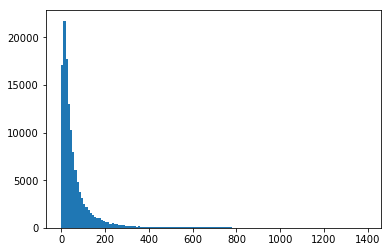

In [1]:
from IPython.display import Image
Image(filename='plots/comment_length_hist.png') 

### Algorithms and Techniques
The general workflow of this project is: 
1. Preprocess the raw data (train/test split, tokenizing).
2. Vectorize tokenized texts.
3. Apply models and evaluate their performances.


- Preprocessing 

In order to split raw texts into tokens, I used the Stanford CoreNLP tokenizer. This tokenizer simply splits word from word, and word from punctuation. For example, the raw sentence "This is a nice day!" will be turned into a list of tokens "This", "is", "a", "nice", "day", "!". The order of the words is preserved. 

- Raw text encoding 

To turn the tokenized texts into features that model can use as input, a vectorizer is applied. In this project, a set of vectorizers was applied, depending on the specific model. The vectorizers used are: count vectorizer (an implementation of bag of words), tfidf vectorizer, GloVe with mean embedding and the embedding provided by keras. 

- Model

I will apply models that takes class weights parameter, such as Logistic Regression, to deal with the situation of imbalanced class distribution. Convolutional neural networks and recurrent neural networks are applied after the feature dimention is reduced by applying embeddings. 

### Benchmark
The Naive Bayes model together with word encoding by bag-of-words is used as a benchmark model. This model itself is straightforward and easy to understand, and usualy works descently well for text classification. The bag-of-words vectorizer has a main disadvantage of ignoring the order of words in a sentence. However, it is a basic approach to start with. 

## III. Methodology

### Data Preprocessing

To process the raw texts, I applied the standford CoreNLP tokenizer to each of the comment. A single comment now has been changed to a list of tokens. 

As mentioned in the Data Exploration section, the data set has imbalanced class distributions for all of the six target labels to some extent. We potentially can down sample the class that has more data, or use bagging technique to create a more balanced dataset. However, I chose to adjust the class-weights parameter that is available to the classifiers to address the imbalanced data problem. 

In order to tune parameters, and compare models, the entire available dataset has been splited into a training set, a validation set, and a test set, using 60%, 20%, and 20% data correspondingly. I chose 20% for both validation set and testing set, considering the most sparse label "severe_toxic" only has 0.10% in the data. 20% of the data should have roughly 30 "severe_toxic" comments, if sampled randomly. Instead of the 3-way split, which reduces the amount of data we can actually train on, cross-validation can be used. I didn't use cross-validation in this project because some of the models I plan to experiment with may take significant training time for each round. Running a k-fold cross-validation will make the training time much longer. At the same time, we have 159571 records in total, which should be considered as enough data to afford a 3-way spliting.


### Model Implementation and Refinement
#### Naive Bayes Classifier 
Naive Bayes model with bag-of-words (BOW) representation has been used as a benchmark. I used $sklearn.feature\_extraction.text.CountVectorizer$ with English stop words to implement BOW. CounterVectorizer ignores the order of tokens in a comment, and simply converts the collection of tokenized comments into a matrix of token counts in the format of sparse representation. Since the counts are discrete features with multiple values, Multinomial Naive Bayes is chosen and implemented by $sklearn.naive\_bayes.MultinomialNB$ with default parameter settings. CountVectorizer is fitted on the training set, then used to transform the validation set before prediction. MultinomialNB is fitted on the vectorized training set, then the fitted model is used to predict probability on the transformed validation set. See the table below for log loss and AUROC for each of the categories and their averages on validation set. The average log loss and AUROC for test set will be shown in the section of Model Evaluation. 

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| Log Loss | 0.4045 | 0.1129 | 0.2815 | 0.0536 | 0.3221 | 0.1541 | 0.2215 |

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| AUROC | 0.8998 | 0.9068 | 0.9037 | 0.8143 | 0.8896 | 0.8107 | 0.8708 |

#### Logistic Regression Classifier 
Logistic regression is a popular model for the case for predicting categorical dependent variables. The data set in this project, each of the categories is a binary variable to predict, which makes logistic regression a practical model to experiment with. Unlike Naive Bayes classifier, logistic regression classifier doesn't make the strong assumption that the features are independent. Also, it is good for imbalanced data, as the penalty for each class can be adjusted by the class weights parameter to improved the improve the imbalanced class distribution. In addition, regulirazation can be paired with logistic regression to prevent overfitting, which is a possible situation in this project, as we have more unique tokens than training records. 

I used the $sklearn.linear_{model}.LogisticRegression$ implementation. One refinement was to replace $CountVectorizer$ with $TFIDF$. TFIDF, short for term frequency–inverse document frequency, intends to indicate the importance of a word to a specific document in a collection of corpus. It helps to deal with the case of frequent words, as it increases to the number of times a word appears in a document and is offset by its frequency in the corpus. As for another refinement, a grid search was applied on the parameter $class\_weights$ and $penalty$. The values tested for $class\_weights$ were $['balanced', \{0:0.9, 1:0.1\}, \{0:0.8, 1:0.2\}, \{0:0.7, 1:0.3\}, \{0:0.6, 1:0.4\}, \{0:0.5, 1:0.5\}, \{0:0.4, 1:0.6\}, \{0:0.3, 1:0.7\}, \{0:0.2, 1:0.8\}, \{0:0.1, 1:0.9\}]$. The values tested for $penalty$ were $\{'l1', 'l2'\}$.  

The combinatin of parameters that gives the lowest log loss and highest AUROC is class 0 weight equals 0.4, class 1 weight equals 0.6, and $l1$ penalty. The corresponding metrics values calculated on for validation set are shown as below. A possible reason for 'l1' penalty giving better result might be that the number of unique words is large, and 'l1' regularization tends to keep fewer non-zero coefficients and in this case prevents overfitting better.
 
| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| Log Loss | 0.2324 | 0.0409 | 0.1351 | 0.0216 | 0.1414 | 0.0434 | 0.1025 |

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| AUROC | 0.9126 | 0.9674 | 0.9299 | 0.9182 | 0.9272 | 0.9284 | 0.9306 |

#### GloVe
Logistic regression gave better results than the benchmark model - Naive Bayes. One may think if more complicated model can do better than logistic regression. However, a limiting factor at this point is the dimension of feature space. No matter we use $CountVectorizer$ or $TfidfVectorizer$, the dimension is the number of unique tokens from training set, which is a fairly large number for implementing deep learning models. 

GloVe is essentially a log-bilinear model with a weighted least-squares objective. The main intuition underlying the model is the simple observation that ratios of word-word co-occurrence probabilities have the potential for encoding some form of meaning. We could potentially train GloVe on the training set, but, one good thing GloVe provides along is the pre-trained vectors on large corpus, we can directly apply these vectors on the tokens of the training set. I chose the word vectors pre-trained on Wikipedia 2014 + Gigaword 5 for this project. 

Now each token is represented as a 50 dimension vector. How can we represent a comment that is consisted with tokens?
A quick heuristic is to use the mean of all vectors of that comment. I experimented this with logistic regression. Unfortunately the resulted metrics were much worse than previous results. I think averaging may have canceled out the information contained in individual words in a comment.

Afterwards, I experimented CNN and RNN with the GloVe as a proper embedding layer. The corresponding validation results are shown in the following two sections. 

#### Convolutional Neural Networks (CNN)

The CNN architecture starts with an embedding layer (in the first implementation, I used pre-trained GloVe), then followed by three Convolutional layers with different numbers of filters (16, 32, 64 correspondingly), and a Max Pooling layer after each of the Convolutional layer, then a Global Average Pooling layer and a Dense layer with proper Dropout layers associated with them. 

The architecture of CNN can be found in the Appendix. 

The implementation of CNN is:
```
#CNN
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = Conv1D(filters=16, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
x = Dense(6, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=x)
```

First I used GloVe as a fixed embedding layer. The log loss and AUROC on the validation set are calculated below.

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| Log Loss | 0.1579 | 0.0329 | 0.0903 | 0.0287 | 0.1017 | 0.0370 | 0.0747 |

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| AUROC | 0.9364 | 0.9679 | 0.9599 | 0.8823 | 0.9521 | 0.9289 | 0.9379 |

I also experimented the same CNN architecture with trainable embedding layer. The log loss is slightly better than using GloVe as embedding layer, but AUROC is at the same level.

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| Log Loss | 0.1294 | 0.0305 | 0.0822 | 0.0260 | 0.0938 | 0.0364 | 0.0664 |

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| AUROC | 0.9559 | 0.9705 | 0.9732 | 0.8375 | 0.9701 | 0.9183 | 0.9376 |


#### Recurrent Neural Networks (RNN)
Different from feedforward neural networks, RNN has internal states to utilize so that it can process sequences. This characteristic is good for natural language processing, because the order of words matters in languages. In this section, I utilized keras $Embedding$ class and built a simple LSTM. Since embedding layer only takes in feature with fixed dimension, I defined a max length. Any comments longer than the max length will be truncated, and $pad_sequences$ is used to make the shorter comments to max length. The max length is chosen as 200, as the marjority of comments are within that length. The network architecture can be found in the Appendix.

The implementation of RNN is:
```
# RNN
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
```

The metrics for RNN with GloVe as embedding layer are listed below. 

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| Log Loss | 0.1107 | 0.0239 | 0.0608 | 0.0177 | 0.0709 | 0.0256 | 0.0516 |

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| AUROC | 0.9704 | 0.9883 | 0.9828 | 0.9575 | 0.9793 | 0.9730 | 0.9752 |

As a refinement, a trainable embedding layer is used to replace GloVe, and both its log loss and AUROC are better for RNN with GloVe.

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| Log Loss | 0.1095 | 0.0246 | 0.0570 | 0.0154 | 0.0683 | 0.0270 | 0.0503 |

| Metric Name | "toxic" | "severe_toxic" | "obscene" | "threat" | "insult" | "identity_hate" | average | 
|--------|-------|--------|-------|--------|-------|--------|--------|
| AUROC | 0.9698 | 0.9861 | 0.9869 | 0.9662 | 0.9812 | 0.9693 | 0.9766 |

## IV. Results

### Model Evaluation and Validation
In the above section, I have implemented three diffrent types of model, and tuned their parameters based on the performance on the validation set. In this section, we'll evaluate the models and select the final model type. Log loss and AUROC are calculated again, but on test set, which has never been exposed in any part of training process yet. 

| Model Name | Average Log Loss | Average AUROC | 
|--------|-------|--------|
| Naive Bayes (benchmark, comparison only) | 0.1512 | 0.8377 |
| Logistic Regression | 0.1020 | 0.9326 |
| CNN | 0.0632 | 0.9393 |
| RNN | 0.0496 | 0.9781 |

Based on calculated log loss and AUROC, my recommendation for the final model is RNN, with a 128 dimension embedding layer, followed by a 60 dimension LSTM layer using hyperbolic tangent activation function, followed by a Global Max Pooling Layer, followed by a Dropout layer with dropout rate of 0.2, followed by a 50 dimension Dense layer with relu activation function, and another Dropout layer with dropout rate of 0.2, then finally a Dense layer with output dimension of 6 and sigmoid activation function.

### Justification

The table in the above section shows the refined RNN has the lowest log loss and highest AUROC. If only evaluated using these two metrics, then RNN is definitely the choice. However, in practice, we may also care operational metrics, such as training time, prediction time, etc. I recorded both the training and prediction time. Relatively, RNN has the longest training time, which is roughly 5 times of CNN's. Logistic regression has the shortest training time, which is only 1/40 of CNN's, and 1/200 of RNN's. If we only need to train one-off model, or the training data doesn't not change dramatically, we probably can still utilize the RNN architect. However, if for some reason, the training data volume increases significantly, the fitting time for each model will all increase with different scales, which may make RNN not an acceptable option any more. And the advantage of logistic regression's low computational time will appear. 

Similar argument applies to the prediction time. Logstic regression has the fastest prediction time, which is roughly 1/2 of CNN's, and 1/14 of RNN's. Depending on how low latency we need for the action followed by the prediction. For example, if we'd like to block the a comment once it's identified as severe toxic, we may want to do so immediately, so that there is a very low chance that any user sees it. 

## V. Conclusion

### Free-Form Visualization

The goal of this project is to identify toxic comments, and correctly categorize them. Thus, this is the most important quality the trained model should have. We surely had a sense through the evaluation metrics calculated above, however, I will demonstrate it more intuitively by showing the predicted probabilities for selected examples from the test dataset.

- Example 1

Raw text:

"GUESS WHAT?

YOUR STILL A DIRTY LITTLE COCK-SUCKING SLUT!"

| Name | toxic | severe_toxic | obscene | threat | insult | identity_hate |
|--|--|--|--|--|--|--|
| true labels |1|1|1|0|1|0|
| predicted probabilities |0.9998|0.5209|0.9825|0.0778|0.9516|0.3401|

The model successfully identified all flagged toxic categories. 

- Example 2

Raw text:

"A silly fat cow who won't leave me alone"

| Name | toxic | severe_toxic | obscene | threat | insult | identity_hate |
|--|--|--|--|--|--|--|
| true labels |1|0|1|0|1|0|
| predicted probabilities |0.9930|0.0258|0.4941|0.0207|0.8126|0.1210 |

The model predicted "toxic" and "insult" with high probabilities, not so well for "obscene".  

- Example 3

Raw text:

"Negro league baseball task-force talk]."

| Name | toxic | severe_toxic | obscene | threat | insult | identity_hate |
|--|--|--|--|--|--|--|
| true labels |0|0|0|0|0|0|
| predicted probabilities |0.6459|0.0016|0.2168|0.0019|0.1542|0.0121|

This is an interesting case, the true labels provided in the test data didn't flag it as any kind of toxic. Judging by my understanding, it seems to be an imcomplete sentence with ambiguous meaning. The word "negro" can possibly be a toxic word, but it's hard for me to categorize its toxity without more context. The model thinks that this comment is toxic, but not very confidently, as the predicted probability for toxic is nowhere close to 1.

### Reflection

In this project, I started from looking at sample data to have an initial understanding of the problem, sketched the outline of problem solving process, selected evaluation metrics, then look through for potential problems with text data, identified the dataset as imbalanced, researched tokenizers and potential models for text categorizing, developed model training pipeline, tuned models by using validation set, and further select the final model according to the performances on test set. 

An important aspect of this project was the learning process, especially the RNN part. RNN was not part of the nano degree curriculum, but during the information gathering period, I discovered in past research and case studies, RNN is a competitive model for text categorization, and I am interested in experimenting with it. I think the actual work in machine learning area will be a discovery journey, the good foundation set by going through the machine learning nano degree, and self-learning capability set me with a good start. 


### Improvement

One thing I've noticed when looking at the specific examples in the conclusion section, is that a good amount of somewhat toxic comments are capitalized. This is a way to indicate strong emotions in written English. Thus, there might be a correlation between capilaization and toxicity. One potential improvement is to extract the capitalization information as a feature, for example, treating the precentage of capital letters of a comment as a continuous feature, or, create a binary feature on if a comment is consisted by all capital letters. 

In this project, I didn't experiment with different RNN or CNN structures, nor fine tune the parameters for them. The reasons are that the current proposed architecture already provided better performance than other models, and training a network takes significant more time. As I learn more about neural networks in the future, I expect to propose and experiment more meaningful network structures. 


## VI. Referrences

- Log loss http://www.exegetic.biz/blog/2015/12/making-sense-logarithmic-loss/
- ROC https://en.wikipedia.org/wiki/Receiver_operating_characteristic
- TFIDF https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- GloVe https://nlp.stanford.edu/projects/glove/
- Bag-of-words model https://en.wikipedia.org/wiki/Bag-of-words_model
- Multinomial distribution - https://en.wikipedia.org/wiki/Multinomial_distribution
- LSTM https://deeplearning4j.org/lstm.html

## VII. Appendix

- CNN architecture

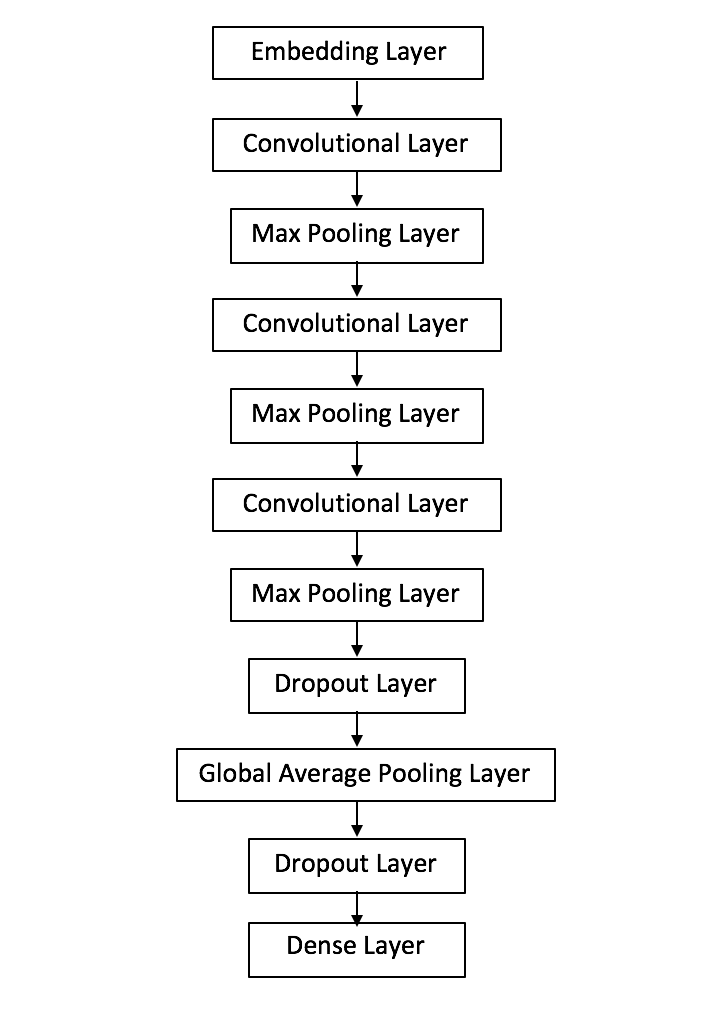

In [4]:
Image(filename='plots/CNN.png') 

- RNN architecture

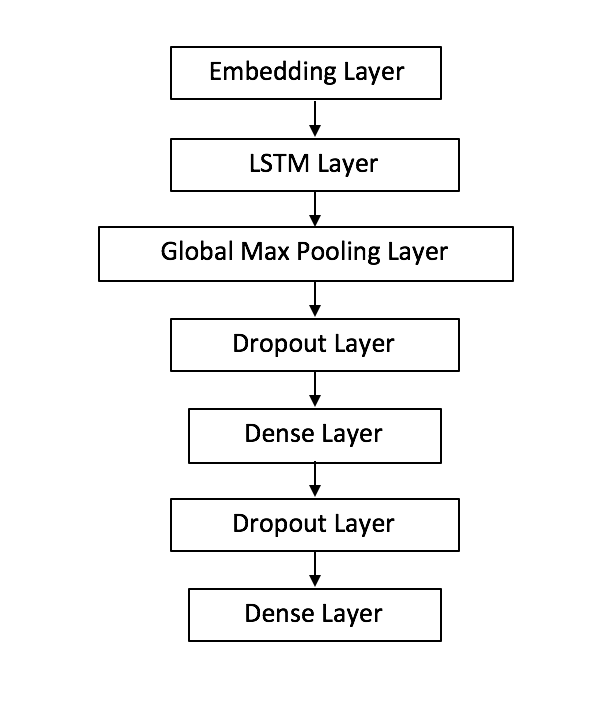

In [6]:
Image(filename='plots/RNN.png') 